# Phase 3 Weighted Bagging

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import os
import re
import csv
import codecs
import gensim
import itertools
import numpy as np
import pandas as pd
import operator
import sys

from nltk import ngrams
from collections import Counter
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from iwillwin.data_utils.feature_engineering import FeatureCreator

from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize

import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import operator
from os import listdir
from os.path import isfile, join

########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
np.random.seed(1337)

import pandas as pd
import operator
import sys

from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from keras.utils import to_categorical

In [ ]:
NB_WORDS, MAX_SEQUENCE_LENGTH = 50000, 50
data_transformer = DataTransformer(max_num_words=NB_WORDS, max_sequence_length=MAX_SEQUENCE_LENGTH, char_level=False,
                                   normalization=True, features_processed=True)
trains_nns, tests_nns, labels = data_transformer.prepare_data(dual=False)
print("Number of unique words", len(data_transformer.tokenizer.index_docs))

In [ ]:
trains_meta = trains_nns[2]
tests_meta = tests_nns[2]

In [ ]:
train_df = pd.read_csv('../data/dataset/train.csv')
test_df = pd.read_csv('../data/dataset/test.csv')

In [ ]:
rumor_words = ['辟谣', '谣言', '勿传', '假的']

def is_rumor(text):
    if type(text) != str:
        print(text, type(text))
        return 0
    for rumor_word in rumor_words:
        if rumor_word in text:
            return 1
    return 0

def has_split_symbol(text):
    if type(text) != str:
        return 0
    if '|' in text:
        return 1
    return 0

for df in [train_df, test_df]:
    df['has_|'] = df['title2_zh'].apply(has_split_symbol)
    df['has_rumor_words'] = df['title2_zh'].apply(is_rumor)

In [ ]:
train_has_rumor = train_df.has_rumor_words.values
test_has_rumor = test_df.has_rumor_words.values

trick_trains_features = np.concatenate((trains_nns[2], train_has_rumor.reshape((-1, 1))), axis=1)
trick_tests_features = np.concatenate((tests_nns[2], test_has_rumor.reshape((-1, 1))), axis=1)

In [ ]:
oof_file_names = sorted([f for f in listdir('../data/pseudo/oofs/') if isfile(join('../data/pseudo/oofs/', f)) and f != '.gitkeep'])
preds_file_names = [name.replace('-Train', '') for name in oof_file_names]

oofs = []
preds = []
for name in oof_file_names:
    oofs.append(pd.read_csv('../data/pseudo/oofs/' + name))
for name in preds_file_names:
    preds.append(pd.read_csv('../data/pseudo/output/' + name))    

In [ ]:
for i, name in enumerate(oof_file_names):
    print(i, name)
    
trains = pd.DataFrame()
tests = pd.DataFrame()

for i in range(len(oof_file_names)):
    for label_type in ['agreed', 'disagreed', 'unrelated']:
        trains['oofs_{}_{}'.format(i, label_type)] = oofs[i][label_type].values
        tests['oofs_pred{}_{}'.format(i, label_type)] = preds[i][label_type].values

In [ ]:
oof_file_names

In [ ]:
unrelated = pd.DataFrame()
agreeds = pd.DataFrame()
disagreeds = pd.DataFrame()

#check_oofs = True
check_oofs = False


if check_oofs:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = oofs[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = oofs[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = oofs[i]['disagreed'].values
else:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = preds[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = preds[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = preds[i]['disagreed'].values  

In [ ]:
agreeds.corr()

In [ ]:
disagreeds.corr()

In [ ]:
unrelated.corr()

# Prepare Different Inputs

In [ ]:
# Only use oofs
ensemble_trains = trains.values
ensemble_tests = tests.values

# LGBM

In [ ]:
from sklearn import metrics

In [27]:
def fit_every_feature_model(feature_data, label, feature_test_data, fold_count=3, predict=True):
    predictions = np.zeros(shape=[len(feature_test_data), 3])
    fold_size = len(feature_data) // fold_count
    oofs = []
    
    log_loss = 0
    for fold_id in range(fold_count):
        print("Fold : ", fold_id)
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        if fold_id == fold_count - 1:
            fold_end = len(feature_data)
                
        train_x = np.concatenate([feature_data[:fold_start], feature_data[fold_end:]])
        train_y = np.concatenate([label[:fold_start], label[fold_end:]])

        val_x = feature_data[fold_start:fold_end]
        val_y = label[fold_start:fold_end]
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        
        lgb_params = {
            'boosting_type' : 'gbdt',
            'objective' : 'multiclass',
            'num_class':3,
            'metric' : {'multi_logloss',},
            'learning_rate' : 0.01,
            'feature_fraction' : 0.8,
            'bagging_fraction': 0.9,
            'bagging_freq': 1,
            'num_leaves' : 16,
            'max_depth': 12,
            'random_state': 42,
            'nthread': 8,
        }
        
        lgbm_model = lgb.train(lgb_params, lgb_train, num_boost_round=100000, valid_sets=[lgb_train, lgb_val],
                        early_stopping_rounds=1000, verbose_eval=100)
        
        lgb.plot_importance(lgbm_model)
        plt.show()
        if predict:
            prediction = lgbm_model.predict(feature_test_data, num_iteration=lgbm_model.best_iteration)
            oof_prediction = lgbm_model.predict(val_x, num_iteration=lgbm_model.best_iteration)
            score = metrics.log_loss(val_y, oof_prediction)
            print("Fold", fold_id, "log loss", score, "in", lgbm_model.best_iteration)
            log_loss += score
            oofs.append(oof_prediction)
            predictions += prediction
            del lgbm_model
    predictions /= fold_count   
    print("Training  Finish")

    return predictions, log_loss / fold_count, oofs

Fold :  0
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.512086	valid_1's multi_logloss: 0.511921
[200]	training's multi_logloss: 0.343642	valid_1's multi_logloss: 0.344914
[300]	training's multi_logloss: 0.285447	valid_1's multi_logloss: 0.288135
[400]	training's multi_logloss: 0.262866	valid_1's multi_logloss: 0.266739
[500]	training's multi_logloss: 0.252742	valid_1's multi_logloss: 0.257765
[600]	training's multi_logloss: 0.247349	valid_1's multi_logloss: 0.253535
[700]	training's multi_logloss: 0.243936	valid_1's multi_logloss: 0.251335
[800]	training's multi_logloss: 0.241614	valid_1's multi_logloss: 0.250113
[900]	training's multi_logloss: 0.239863	valid_1's multi_logloss: 0.249397
[1000]	training's multi_logloss: 0.238458	valid_1's multi_logloss: 0.248997
[1100]	training's multi_logloss: 0.237279	valid_1's multi_logloss: 0.248746
[1200]	training's multi_logloss: 0.236236	valid_1's multi_logloss: 0.248587
[1300]	training's multi

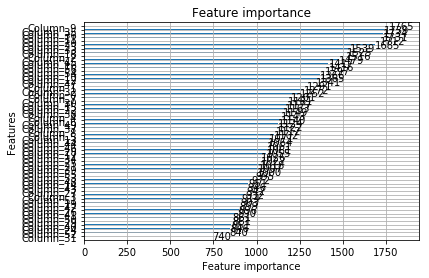

Fold 0 log loss 0.24844021676400113 in 1484
Fold :  1
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.51385	valid_1's multi_logloss: 0.496529
[200]	training's multi_logloss: 0.345911	valid_1's multi_logloss: 0.324752
[300]	training's multi_logloss: 0.287884	valid_1's multi_logloss: 0.266298
[400]	training's multi_logloss: 0.26534	valid_1's multi_logloss: 0.244532
[500]	training's multi_logloss: 0.255199	valid_1's multi_logloss: 0.235514
[600]	training's multi_logloss: 0.249766	valid_1's multi_logloss: 0.231331
[700]	training's multi_logloss: 0.246365	valid_1's multi_logloss: 0.229177
[800]	training's multi_logloss: 0.244046	valid_1's multi_logloss: 0.228021
[900]	training's multi_logloss: 0.242288	valid_1's multi_logloss: 0.227324
[1000]	training's multi_logloss: 0.240886	valid_1's multi_logloss: 0.226907
[1100]	training's multi_logloss: 0.239698	valid_1's multi_logloss: 0.226685
[1200]	training's multi_logloss: 0.238645	valid_1's multi

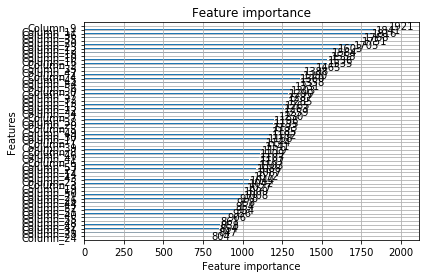

Fold 1 log loss 0.2264450023111016 in 1562
Fold :  2
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.51208	valid_1's multi_logloss: 0.512659
[200]	training's multi_logloss: 0.343621	valid_1's multi_logloss: 0.345331
[300]	training's multi_logloss: 0.285443	valid_1's multi_logloss: 0.288294
[400]	training's multi_logloss: 0.262838	valid_1's multi_logloss: 0.266694
[500]	training's multi_logloss: 0.252696	valid_1's multi_logloss: 0.257493
[600]	training's multi_logloss: 0.247267	valid_1's multi_logloss: 0.253062
[700]	training's multi_logloss: 0.243847	valid_1's multi_logloss: 0.250743
[800]	training's multi_logloss: 0.241501	valid_1's multi_logloss: 0.249385
[900]	training's multi_logloss: 0.239764	valid_1's multi_logloss: 0.24864
[1000]	training's multi_logloss: 0.238368	valid_1's multi_logloss: 0.248196
[1100]	training's multi_logloss: 0.237202	valid_1's multi_logloss: 0.247929
[1200]	training's multi_logloss: 0.236163	valid_1's multi_

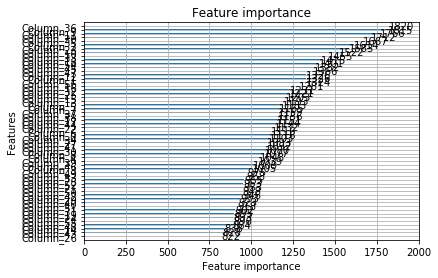

Fold 2 log loss 0.24760319745696935 in 1487
Fold :  3
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.511128	valid_1's multi_logloss: 0.5223
[200]	training's multi_logloss: 0.342462	valid_1's multi_logloss: 0.356705
[300]	training's multi_logloss: 0.284233	valid_1's multi_logloss: 0.299675
[400]	training's multi_logloss: 0.261635	valid_1's multi_logloss: 0.277875
[500]	training's multi_logloss: 0.251534	valid_1's multi_logloss: 0.26846
[600]	training's multi_logloss: 0.246128	valid_1's multi_logloss: 0.263953
[700]	training's multi_logloss: 0.24274	valid_1's multi_logloss: 0.26163
[800]	training's multi_logloss: 0.240431	valid_1's multi_logloss: 0.260369
[900]	training's multi_logloss: 0.238694	valid_1's multi_logloss: 0.259665
[1000]	training's multi_logloss: 0.237264	valid_1's multi_logloss: 0.259271
[1100]	training's multi_logloss: 0.236084	valid_1's multi_logloss: 0.259044
[1200]	training's multi_logloss: 0.235017	valid_1's multi_lo

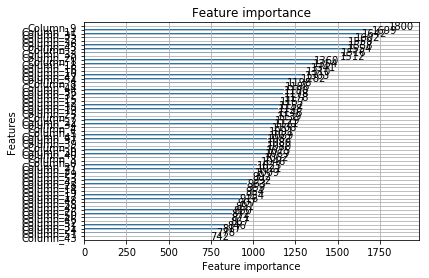

Fold 3 log loss 0.2587995577455934 in 1452
Fold :  4
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.513209	valid_1's multi_logloss: 0.505408
[200]	training's multi_logloss: 0.345026	valid_1's multi_logloss: 0.334664
[300]	training's multi_logloss: 0.286911	valid_1's multi_logloss: 0.276047
[400]	training's multi_logloss: 0.264314	valid_1's multi_logloss: 0.253841
[500]	training's multi_logloss: 0.254167	valid_1's multi_logloss: 0.244557
[600]	training's multi_logloss: 0.248751	valid_1's multi_logloss: 0.240218
[700]	training's multi_logloss: 0.245323	valid_1's multi_logloss: 0.237952
[800]	training's multi_logloss: 0.242989	valid_1's multi_logloss: 0.236736
[900]	training's multi_logloss: 0.241241	valid_1's multi_logloss: 0.236039
[1000]	training's multi_logloss: 0.239823	valid_1's multi_logloss: 0.235659
[1100]	training's multi_logloss: 0.238643	valid_1's multi_logloss: 0.235421
[1200]	training's multi_logloss: 0.237584	valid_1's mult

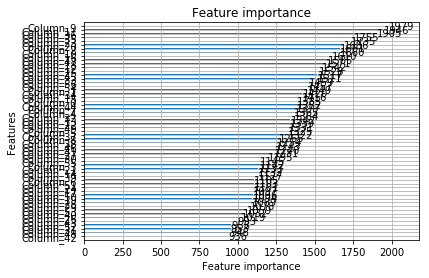

Fold 4 log loss 0.23519924303988526 in 1682
Fold :  5
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.511386	valid_1's multi_logloss: 0.519316
[200]	training's multi_logloss: 0.342822	valid_1's multi_logloss: 0.353108
[300]	training's multi_logloss: 0.284588	valid_1's multi_logloss: 0.295891
[400]	training's multi_logloss: 0.261981	valid_1's multi_logloss: 0.274282
[500]	training's multi_logloss: 0.251821	valid_1's multi_logloss: 0.265196
[600]	training's multi_logloss: 0.246396	valid_1's multi_logloss: 0.260917
[700]	training's multi_logloss: 0.242982	valid_1's multi_logloss: 0.258743
[800]	training's multi_logloss: 0.240643	valid_1's multi_logloss: 0.257535
[900]	training's multi_logloss: 0.238927	valid_1's multi_logloss: 0.25684
[1000]	training's multi_logloss: 0.237529	valid_1's multi_logloss: 0.256419
[1100]	training's multi_logloss: 0.236365	valid_1's multi_logloss: 0.2562
[1200]	training's multi_logloss: 0.235319	valid_1's multi_

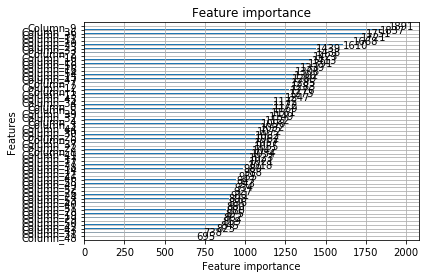

Fold 5 log loss 0.2560397692230624 in 1458
Fold :  6
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.509893	valid_1's multi_logloss: 0.530119
[200]	training's multi_logloss: 0.341026	valid_1's multi_logloss: 0.368924
[300]	training's multi_logloss: 0.282825	valid_1's multi_logloss: 0.314204
[400]	training's multi_logloss: 0.260286	valid_1's multi_logloss: 0.293334
[500]	training's multi_logloss: 0.25022	valid_1's multi_logloss: 0.284255
[600]	training's multi_logloss: 0.244831	valid_1's multi_logloss: 0.279804
[700]	training's multi_logloss: 0.241458	valid_1's multi_logloss: 0.277509
[800]	training's multi_logloss: 0.239154	valid_1's multi_logloss: 0.276229
[900]	training's multi_logloss: 0.23745	valid_1's multi_logloss: 0.275477
[1000]	training's multi_logloss: 0.236079	valid_1's multi_logloss: 0.27504
[1100]	training's multi_logloss: 0.234917	valid_1's multi_logloss: 0.274794
[1200]	training's multi_logloss: 0.233889	valid_1's multi_l

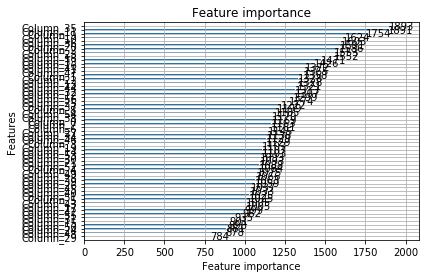

Fold 6 log loss 0.27448999748736214 in 1541
Fold :  7
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.511683	valid_1's multi_logloss: 0.516436
[200]	training's multi_logloss: 0.343204	valid_1's multi_logloss: 0.349574
[300]	training's multi_logloss: 0.285039	valid_1's multi_logloss: 0.292138
[400]	training's multi_logloss: 0.262445	valid_1's multi_logloss: 0.27027
[500]	training's multi_logloss: 0.252303	valid_1's multi_logloss: 0.260979
[600]	training's multi_logloss: 0.24684	valid_1's multi_logloss: 0.256593
[700]	training's multi_logloss: 0.243417	valid_1's multi_logloss: 0.254369
[800]	training's multi_logloss: 0.241085	valid_1's multi_logloss: 0.253174
[900]	training's multi_logloss: 0.239326	valid_1's multi_logloss: 0.252515
[1000]	training's multi_logloss: 0.237902	valid_1's multi_logloss: 0.252126
[1100]	training's multi_logloss: 0.236698	valid_1's multi_logloss: 0.251918
[1200]	training's multi_logloss: 0.235649	valid_1's multi

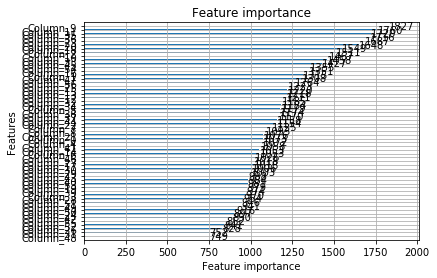

Fold 7 log loss 0.2516691731417232 in 1479
Fold :  8
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.51211	valid_1's multi_logloss: 0.514966
[200]	training's multi_logloss: 0.343669	valid_1's multi_logloss: 0.347155
[300]	training's multi_logloss: 0.285452	valid_1's multi_logloss: 0.289547
[400]	training's multi_logloss: 0.262802	valid_1's multi_logloss: 0.267916
[500]	training's multi_logloss: 0.252634	valid_1's multi_logloss: 0.258828
[600]	training's multi_logloss: 0.247237	valid_1's multi_logloss: 0.254537
[700]	training's multi_logloss: 0.243864	valid_1's multi_logloss: 0.25237
[800]	training's multi_logloss: 0.241549	valid_1's multi_logloss: 0.251184
[900]	training's multi_logloss: 0.239802	valid_1's multi_logloss: 0.250509
[1000]	training's multi_logloss: 0.23841	valid_1's multi_logloss: 0.250148
[1100]	training's multi_logloss: 0.237212	valid_1's multi_logloss: 0.249927
[1200]	training's multi_logloss: 0.236171	valid_1's multi_l

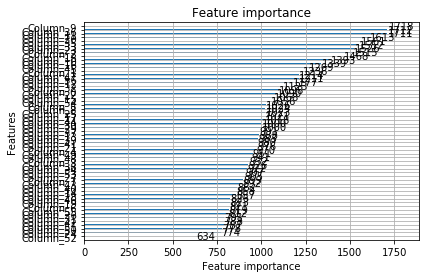

Fold 8 log loss 0.24977507248569505 in 1359
Fold :  9
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.512523	valid_1's multi_logloss: 0.508189
[200]	training's multi_logloss: 0.344236	valid_1's multi_logloss: 0.339585
[300]	training's multi_logloss: 0.286094	valid_1's multi_logloss: 0.281985
[400]	training's multi_logloss: 0.263489	valid_1's multi_logloss: 0.260472
[500]	training's multi_logloss: 0.25331	valid_1's multi_logloss: 0.251549
[600]	training's multi_logloss: 0.247882	valid_1's multi_logloss: 0.247389
[700]	training's multi_logloss: 0.244469	valid_1's multi_logloss: 0.245295
[800]	training's multi_logloss: 0.242118	valid_1's multi_logloss: 0.244157
[900]	training's multi_logloss: 0.240374	valid_1's multi_logloss: 0.243498
[1000]	training's multi_logloss: 0.238964	valid_1's multi_logloss: 0.243101
[1100]	training's multi_logloss: 0.237781	valid_1's multi_logloss: 0.242878
[1200]	training's multi_logloss: 0.236706	valid_1's mult

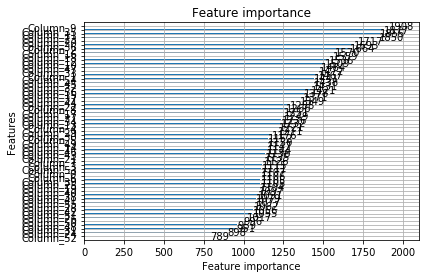

Fold 9 log loss 0.242608917247828 in 1622
Training  Finish


In [28]:
pred, log_loss, oofs = fit_every_feature_model(ensemble_trains, labels, ensemble_tests, fold_count=10)

In [29]:
log_loss

0.24910701469032212

In [30]:
oofs = np.concatenate(oofs)
oofs.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
def np_weighted_accuracy(y_true, y_pred):
    weight = np.array([[1/16, 1/15, 1/5]])
    norm = [(1/16) + (1/15) + (1/5)]
    weight_mask = weight * y_true
    weight_mask = np.max(weight_mask, axis=-1)
    norms = np.sum(weight_mask)
    
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    
    res = ((y_true == y_pred) * weight_mask).sum() / norms
    return res

In [32]:
score = np_weighted_accuracy(to_categorical(labels), oofs)

In [33]:
score

0.8686099870681093

In [34]:
print("score", score)
oofs_dir = "../data/p_ensemble/oofs/"
output_dir = "../data/p_ensemble/preds/"
onehot_pred_dir = "../data/p_ensemble/nn_one_hot/"

model_submit_prefix = "LightGBM-Ensemble"

oofs_path = oofs_dir + model_submit_prefix
output_path = output_dir + model_submit_prefix
one_hot_pred_path = onehot_pred_dir + "One-Hot" + model_submit_prefix

print("Predicting training results...")
oofs = pd.DataFrame({"unrelated": oofs[:, 0], "agreed": oofs[:, 1], "disagreed": oofs[:, 2]})
submit_path = oofs_path + "-Train-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
oofs.to_csv(submit_path, index=False)

test_predicts = pd.DataFrame({"unrelated": pred[:, 0], "agreed": pred[:, 1], "disagreed": pred[:, 2]})
submit_path = output_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
test_predicts.to_csv(submit_path, index=False) # 0.3343

print("Predicting labeled testing results...")
ids = pd.read_csv("../data/dataset/test.csv")
pred_labels = test_predicts.idxmax(axis=1)
sub = pd.DataFrame({"Id": ids['id'].values, "Category": pred_labels})
submit_path = one_hot_pred_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
sub.to_csv(submit_path, index=False)

score 0.8686099870681093
Predicting training results...
Predicting labeled testing results...
